# Lecture overview

In this lecture we introduce a set of Pandas functions that are very useful in describing subsamples of your data (this is often called "subsample analysis"). Looking at subsamples of your data individually is important because patterns that show up in your overall dataset may look quite different if you limit yourself to a subset of the dataset. This is exemplified in Simpson's Paradox: https://en.wikipedia.org/wiki/Simpson%27s_paradox.

We finish the lecture with a discussion of the impact of outliers on your descriptive statistics, and a method of mitigating that impact called "windsorization".

# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
pd.options.display.max_rows = 20

We'll use data on the Fama-French 5-industry portfolio returns for this lecture:

In [2]:
raw = pdr.DataReader(name = '5_Industry_Portfolios', data_source = 'famafrench', 
                     start = '2011-01-01', end = '2020-12-31')
raw

{0:          Cnsmr  Manuf  HiTec  Hlth   Other
 Date                                      
 2011-01  -1.34   4.20   3.00  -0.71   1.92
 2011-02   2.89   4.87   3.45   3.33   2.63
 2011-03   1.89   1.81  -0.83   2.29  -0.86
 2011-04   4.36   2.58   3.16   6.37   1.11
 2011-05   0.92  -2.55  -1.13   1.96  -2.40
 ...        ...    ...    ...    ...    ...
 2020-08  10.07   3.15  10.00   2.45   7.20
 2020-09  -4.01  -2.24  -4.82  -1.47  -2.98
 2020-10  -2.64  -0.03  -2.02  -4.42  -1.88
 2020-11  11.44  12.91  11.16   9.51  15.76
 2020-12   4.09   2.65   4.99   4.77   5.27
 
 [120 rows x 5 columns],
 1:          Cnsmr  Manuf  HiTec  Hlth   Other
 Date                                      
 2011-01  -0.54   3.64   3.18   1.26   1.88
 2011-02   4.14   5.50   5.49   3.46   2.92
 2011-03   1.15   3.33   0.88   2.77  -0.48
 2011-04   2.32   0.47   1.45   5.02   0.23
 2011-05  -1.00  -3.48  -1.78  -0.18  -2.72
 ...        ...    ...    ...    ...    ...
 2020-08   9.79   3.39   4.02   1.41   5.59

Extract equal-weighted *annual* industry returns, and turn them to decimal (they are in percentage points):

In [3]:
ew = raw[3]/100
ew

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.0673,-0.0602,-0.1344,-0.1095,-0.1041
2012,0.2199,0.0897,0.1064,0.2544,0.2582
2013,0.4372,0.3733,0.5077,0.5615,0.4226
2014,0.0487,-0.0846,0.0241,0.1420,0.0792
2015,-0.0962,-0.2243,-0.0348,0.0235,-0.0305
2016,0.1605,0.3362,0.1730,-0.1121,0.3099
2017,0.0642,0.1037,0.2578,0.2549,0.1459
2018,-0.1413,-0.2204,-0.0641,-0.2248,-0.1387
2019,0.1749,0.1204,0.2763,0.2596,0.2627


Let's take a look at the data:

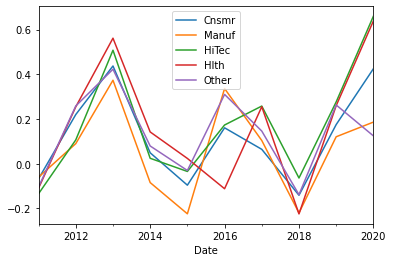

In [4]:
ew.plot();

Calculate cumulative products of gross returns (i.e. compound returns over time) and plot them:

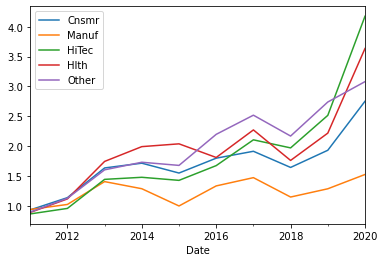

In [5]:
(1+ew).cumprod().plot();

Stack industry returns on top of each other for the purpose of this class:

In [6]:
ew_long = ew.stack().to_frame(name = 'ewret')
ew_long.head(10)

ewret
Date              
2011 Cnsmr -0.0673
     Manuf -0.0602
     HiTec -0.1344
     Hlth  -0.1095
     Other -0.1041
2012 Cnsmr  0.2199
     Manuf  0.0897
     HiTec  0.1064
     Hlth   0.2544
     Other  0.2582

And bring date and industry names as data inside the dataframe:

In [7]:
ew_long = ew_long.reset_index().rename(columns = {'level_1':'Industry'})
ew_long.head(2)

,Date,Industry,ewret
0,2011,Cnsmr,-0.0673
1,2011,Manuf,-0.0602


**Challenge:**

Do the same for value-weighted annual returns (i.e. create a "vw_long" dataframe, using the same steps we used for "ew_long":

In [8]:
vw = raw[2]/100
vw

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,0.0905,0.0447,0.0049,0.1087,-0.0989
2012,0.1630,0.0881,0.1673,0.2035,0.2227
2013,0.3299,0.2918,0.3365,0.4119,0.4086
2014,0.1263,0.0338,0.1448,0.2446,0.1234
2015,0.0679,-0.1164,0.0383,0.0580,-0.0115
2016,0.0548,0.2034,0.1398,-0.0185,0.2017
2017,0.1868,0.1817,0.2950,0.2220,0.2152
2018,-0.0358,-0.1110,-0.0059,0.0482,-0.0923
2019,0.2588,0.2121,0.4185,0.2020,0.2950


In [9]:
vw_long = vw.stack().to_frame(name = 'vwret')\
            .reset_index().rename(columns={'level_1':'Industry'})

vw_long.head()

,Date,Industry,vwret
0,2011,Cnsmr,0.0905
1,2011,Manuf,0.0447
2,2011,HiTec,0.0049
3,2011,Hlth,0.1087
4,2011,Other,-0.0989


Merge the EW returns and VW returns into a single dataframe called "ireturns":

In [10]:
ireturns = ew_long.merge(vw_long, how='inner', on = ['Date','Industry'])
ireturns.head(10)

,Date,Industry,ewret,vwret
0,2011,Cnsmr,-0.0673,0.0905
1,2011,Manuf,-0.0602,0.0447
2,2011,HiTec,-0.1344,0.0049
3,2011,Hlth,-0.1095,0.1087
4,2011,Other,-0.1041,-0.0989
5,2012,Cnsmr,0.2199,0.1630
6,2012,Manuf,0.0897,0.0881
7,2012,HiTec,0.1064,0.1673
8,2012,Hlth,0.2544,0.2035
9,2012,Other,0.2582,0.2227


# Grouping your data: the ``.groupby()`` function

The ``.groupby()`` function can be used to tell Python that you want to split your data into groups. The parameters of the ``.groupby()`` function tell Python *how* those groups should be created. The purpose is usually to apply some function (e.g. the ".mean()" function) to each of these groups separately.

Abbreviated syntax:
```python
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, dropna=True)
```

The most important parameter is ``by``. This is where you tell Python which column (or index) in your DataFrame contains the information based on which you want to group your data. Python will split your DataFrame into "mini" dataframes, one for each unique value of the variable(s) you supplied to the ``by`` parameter.

For example, the line below splits ``ireturns`` into 5 different dataframes, one for each unique entry found in the "Industry" column, and then applies the ``.mean()`` function for each of these 5 dataframes separately. Finally, these subsample means are all collected into a new dataframe ``ind_means``: 

In [11]:
ind_means = ireturns.groupby(by = 'Industry').mean()
ind_means

,ewret,vwret
Industry,,
Cnsmr,0.12253,0.16186
HiTec,0.17717,0.19657
Hlth,0.16880,0.16635
Manuf,0.06198,0.08308
Other,0.13297,0.13327


If you don't want the ``by`` variable (i.e. "Industry" in the example above) to be the index of the resulting dataframe:

In [12]:
ind_means = ireturns.groupby(by = 'Industry', as_index = False).mean()
ind_means

,Industry,ewret,vwret
0,Cnsmr,0.12253,0.16186
1,HiTec,0.17717,0.19657
2,Hlth,0.16880,0.16635
3,Manuf,0.06198,0.08308
4,Other,0.13297,0.13327


Another example, with a different ``by`` variable and a different function applied to each group (i.e. median instead of mean):

In [13]:
an_means = ireturns.groupby(by = 'Date').median()
an_means

,ewret,vwret
Date,,
2011,-0.1041,0.0447
2012,0.2199,0.1673
2013,0.4372,0.3365
2014,0.0487,0.1263
2015,-0.0348,0.0383
2016,0.1730,0.1398
2017,0.1459,0.2152
2018,-0.1413,-0.0358
2019,0.2596,0.2588


You can group by more than one variable:

In [14]:
twodim = ireturns.groupby(by = ['Date','Industry']).mean()
twodim.head(10)

ewret   vwret
Date Industry                
2011 Cnsmr    -0.0673  0.0905
     HiTec    -0.1344  0.0049
     Hlth     -0.1095  0.1087
     Manuf    -0.0602  0.0447
     Other    -0.1041 -0.0989
2012 Cnsmr     0.2199  0.1630
     HiTec     0.1064  0.1673
     Hlth      0.2544  0.2035
     Manuf     0.0897  0.0881
     Other     0.2582  0.2227

The example above did not really change the ``ireturns`` dataframe, since each "Date" x "Industry" pair has a single entry for both "ewret" and "vwret". Since the mean of a single number is the number itself, the ``twodim`` dataframe will be identical to ``ireturns``. Note that this is not necessarily the case if we used a different function instead of ``.mean()``, for example ``.count()``:

In [15]:
twodim = ireturns.groupby(by = ['Date','Industry']).count()
twodim.head(10)

ewret  vwret
Date Industry              
2011 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1
2012 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1

You can specify which variable(s) you want to apply the function to, in brackets, right before the function name (if you leave this out (like above), the function will be applied to all the columns in the dataframe):

In [16]:
ind_ew_medians = ireturns.groupby('Industry')['ewret'].median()
ind_ew_medians

Industry
Cnsmr    0.11235
HiTec    0.13970
Hlth     0.19820
Manuf    0.09670
Other    0.13520
Name: ewret, dtype: float64

# The ``.apply()`` and ``.transform()`` methods

The ``.apply()`` and ``.transform()``  methods do similar things: they can be used to tell Python to apply a given function to some data from a dataframe. As the examples above show, there are many Pandas functions, like ``.mean()`` and ``.median()`` that can do this without the help of ``.apply()`` or ``.transform()`` (we just have to add the names of these functions after the ``.groupby()`` statement, just like we did above). But what if the function we want to apply is not a built-in Pandas function that can be applied with a dot after the name of a dataframe? This is where ``.apply()`` and ``.transform()`` come in handy. These methods are especially useful when we want to apply a particular function, separately, to each group we created with a ``.groupby`` statement. 

Here is their syntax:

Syntax for ``.transform()``:
```python
DataFrame.transform(func, axis=0, *args, **kwargs)
```
Syntax for ``.apply()``:
```python
DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwargs)
```

The most important argument is ``func`` which is where we tell Python which function we want to apply to the data. 

The main difference between ``.transform()`` and ``.apply()`` is that ``.transform()`` returns a sequence of the same length as the dataframe to which it is applied, while ``.apply()`` returns a DataFrame or Series of the same size as the number of groups to which it is applied.

In [17]:
ireturns.groupby('Industry')['ewret'].apply(func = np.median)

Industry
Cnsmr    0.11235
HiTec    0.13970
Hlth     0.19820
Manuf    0.09670
Other    0.13520
Name: ewret, dtype: float64

In [18]:
ireturns.groupby('Industry')['ewret'].transform(func = np.median)

0     0.11235
1     0.09670
2     0.13970
3     0.19820
4     0.13520
       ...   
45    0.11235
46    0.09670
47    0.13970
48    0.19820
49    0.13520
Name: ewret, Length: 50, dtype: float64

We usually add the results of ``.transform()`` as a new column to the same dataframe:

In [19]:
mycopy = ireturns.copy()
mycopy['ind_medians'] = mycopy.groupby('Industry')['ewret'].transform(np.median)
mycopy.head(10)

,Date,Industry,ewret,vwret,ind_medians
0,2011,Cnsmr,-0.0673,0.0905,0.11235
1,2011,Manuf,-0.0602,0.0447,0.09670
2,2011,HiTec,-0.1344,0.0049,0.13970
3,2011,Hlth,-0.1095,0.1087,0.19820
4,2011,Other,-0.1041,-0.0989,0.13520
5,2012,Cnsmr,0.2199,0.1630,0.11235
6,2012,Manuf,0.0897,0.0881,0.09670
7,2012,HiTec,0.1064,0.1673,0.13970
8,2012,Hlth,0.2544,0.2035,0.19820
9,2012,Other,0.2582,0.2227,0.13520


Note, also, that with ``.transform()``, you can pass the name of the function you want as a **string** to the ``func`` argument, whereas with ``.apply()`` you can not:

In [20]:
ireturns.groupby('Industry')[['ewret','vwret']].transform('median') 

,ewret,vwret
0,0.11235,0.14465
1,0.09670,0.06640
2,0.13970,0.15605
3,0.19820,0.19255
4,0.13520,0.16255
...,...,...
45,0.11235,0.14465
46,0.09670,0.06640
47,0.13970,0.15605
48,0.19820,0.19255


Whereas the line below will not work. You have to specify which package the "median" function belongs to (which is why we used ``.apply(np.median)`` above):

In [21]:
#ireturns.groupby('Industry')[['ewret','vwret']].apply('median') #this gives an error

We are not restricted to applying functions that come with a package that we have installed. We can also use a function that we created ourselves.

For example, below, we create a function that can take in a Series or a DataFrame of returns, and compounds them:

In [22]:
def compound_returns(x):
    return (1+x).prod()-1

Now we can apply that function to the returns of each industry:

In [23]:
ireturns.groupby('Industry')[['ewret','vwret']].apply(compound_returns)

,ewret,vwret
Industry,,
Cnsmr,1.751321,3.242533
HiTec,3.174702,4.532945
Hlth,2.634393,3.435179
Manuf,0.525684,1.060787
Other,2.079929,2.161870


Let's see if it worked:

In [24]:
(1+ew).cumprod()-1 #look at the bottom row and compare it with our results above

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.067300,-0.060200,-0.134400,-0.109500,-0.104100
2012,0.137801,0.024100,-0.042300,0.117043,0.127221
2013,0.635247,0.406397,0.443924,0.744263,0.603585
2014,0.714884,0.287415,0.478723,0.991948,0.730589
2015,0.549912,-0.001352,0.427263,1.038759,0.677806
2016,0.798673,0.334394,0.674180,0.810214,1.197758
2017,0.914148,0.472770,1.105783,1.271638,1.518411
2018,0.643679,0.148172,0.970802,0.760974,1.169108
2019,0.931158,0.286412,1.515335,1.218122,1.738932


# Winsorizing outliers 

"Winsorizing" a variable means replacing its most extreme values with less extreme values. For example, winsorizing a variable "at the 5 and 95 percentiles", means that the values of that variable that are smaller than the 5th percentile will be made equal to the 5th percentile and the values that are larger than the 95th percentile will be made equal to the 95th percentile.

You can pick other values for the percentiles at which you want to winsorize but (1,99) and (5, 95) are by far the most common ones.

To winsorize a variable, in a Pandas dataframe, we use the ``.clip()`` function as below. This also requires us to use the ``.quantile()`` function to calculate the 5th and 95th percentiles. First, let's sort the returns so we can easily see its most extreme values (top and bottom):

In [25]:
ew_long.sort_values('ewret')

,Date,Industry,ewret
38,2018,Hlth,-0.2248
21,2015,Manuf,-0.2243
36,2018,Manuf,-0.2204
35,2018,Cnsmr,-0.1413
39,2018,Other,-0.1387
...,...,...,...
10,2013,Cnsmr,0.4372
12,2013,HiTec,0.5077
13,2013,Hlth,0.5615
48,2020,Hlth,0.6385


Let's calculate the 5th and 95th percentiles:

In [26]:
q5 = ew_long['ewret'].quantile(0.05)
q5

-0.184805

In [27]:
q95 = ew_long['ewret'].quantile(0.95)
q95

0.5372899999999998

And now let's create a version of ``ewret`` that is winsorized at the 5 and 95 percentiles:

In [28]:
ew_long['ew_wins'] = ew_long['ewret'].clip(lower = q5, upper = q95)

Let's see if it worked:

In [29]:
ew_long.sort_values('ewret')

,Date,Industry,ewret,ew_wins
38,2018,Hlth,-0.2248,-0.184805
21,2015,Manuf,-0.2243,-0.184805
36,2018,Manuf,-0.2204,-0.184805
35,2018,Cnsmr,-0.1413,-0.141300
39,2018,Other,-0.1387,-0.138700
...,...,...,...,...
10,2013,Cnsmr,0.4372,0.437200
12,2013,HiTec,0.5077,0.507700
13,2013,Hlth,0.5615,0.537290
48,2020,Hlth,0.6385,0.537290
